# PTN Template
This notebook serves as a template for single dataset PTN experiments  
It can be run on its own by setting STANDALONE to True (do a find for "STANDALONE" to see where)  
But it is intended to be executed as part of a *papermill.py script. See any of the   
experimentes with a papermill script to get started with that workflow.  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Required Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "labels_source",
    "labels_target",
    "domains_source",
    "domains_target",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "n_shot",
    "n_way",
    "n_query",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_transforms_source",
    "x_transforms_target",
    "episode_transforms_source",
    "episode_transforms_target",
    "pickle_name",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "torch_default_dtype"
}

In [3]:


standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337


standalone_parameters["num_examples_per_domain_per_label_source"]=100
standalone_parameters["num_examples_per_domain_per_label_target"]=100

standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 100

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "target_accuracy"

standalone_parameters["x_transforms_source"] = ["unit_power"]
standalone_parameters["x_transforms_target"] = ["unit_power"]
standalone_parameters["episode_transforms_source"] = []
standalone_parameters["episode_transforms_target"] = []

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

# uncomment for CORES dataset
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)


standalone_parameters["labels_source"] = ALL_NODES
standalone_parameters["labels_target"] = ALL_NODES

standalone_parameters["domains_source"] = [1]
standalone_parameters["domains_target"] = [2,3,4,5]

standalone_parameters["pickle_name"] = "cores.stratified_ds.2022A.pkl"


# Uncomment these for ORACLE dataset
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )
# standalone_parameters["labels_source"] = ALL_SERIAL_NUMBERS
# standalone_parameters["labels_target"] = ALL_SERIAL_NUMBERS
# standalone_parameters["domains_source"] = [8,20, 38,50]
# standalone_parameters["domains_target"] = [14, 26, 32, 44, 56]
# standalone_parameters["pickle_name"] = "oracle.frame_indexed.stratified_ds.2022A.pkl"
# standalone_parameters["num_examples_per_domain_per_label_source"]=1000
# standalone_parameters["num_examples_per_domain_per_label_target"]=1000

# Uncomment these for Metahan dataset
# standalone_parameters["labels_source"] = list(range(19))
# standalone_parameters["labels_target"] = list(range(19))
# standalone_parameters["domains_source"] = [0]
# standalone_parameters["domains_target"] = [1]
# standalone_parameters["pickle_name"] = "metehan.stratified_ds.2022A.pkl"
# standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])
# standalone_parameters["num_examples_per_domain_per_label_source"]=200
# standalone_parameters["num_examples_per_domain_per_label_target"]=100


standalone_parameters["n_way"]  = len(standalone_parameters["labels_source"])

In [4]:
# Parameters
parameters = {
    "experiment_name": "nShot_oracle.run2",
    "device": "cuda",
    "lr": 0.001,
    "seed": 1337,
    "dataset_seed": 1337,
    "labels_source": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "labels_target": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "x_transforms_source": [],
    "x_transforms_target": [],
    "episode_transforms_source": [],
    "episode_transforms_target": [],
    "num_examples_per_domain_per_label_source": 1000,
    "num_examples_per_domain_per_label_target": 1000,
    "n_way": 16,
    "n_query": 2,
    "train_k_factor": 1,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_loss",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "pickle_name": "oracle.Run2_10kExamples_stratified_ds.2022A.pkl",
    "n_shot": 10,
    "domains_source": [8, 32, 50],
    "domains_target": [14, 20, 26, 38, 44],
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
# (This is due to the randomized initial weights)
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
###################################
# Build the dataset
###################################

if p.x_transforms_source == []: x_transform_source = None
else: x_transform_source = get_chained_transform(p.x_transforms_source) 

if p.x_transforms_target == []: x_transform_target = None
else: x_transform_target = get_chained_transform(p.x_transforms_target)

if p.episode_transforms_source == []: episode_transform_source = None
else: raise Exception("episode_transform_source not implemented")

if p.episode_transforms_target == []: episode_transform_target = None
else: raise Exception("episode_transform_target not implemented")


eaf_source = Episodic_Accessor_Factory(
    labels=p.labels_source,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_source,
    example_transform_func=episode_transform_source,
    
)
train_original_source, val_original_source, test_original_source = eaf_source.get_train(), eaf_source.get_val(), eaf_source.get_test()


eaf_target = Episodic_Accessor_Factory(
    labels=p.labels_target,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_target,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name),
    x_transform_func=x_transform_target,
    example_transform_func=episode_transform_target,
)
train_original_target, val_original_target, test_original_target = eaf_target.get_train(), eaf_target.get_val(), eaf_target.get_test()


transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
# Some quick unit tests on the data
from steves_utils.transforms import get_average_power, get_average_magnitude

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_source))

assert q_x.dtype == eval(p.torch_default_dtype)
assert s_x.dtype == eval(p.torch_default_dtype)

print("Visually inspect these to see if they line up with expected values given the transforms")
print('x_transforms_source', p.x_transforms_source)
print('x_transforms_target', p.x_transforms_target)
print("Average magnitude, source:", get_average_magnitude(q_x[0].numpy()))
print("Average power, source:", get_average_power(q_x[0].numpy()))

q_x, q_y, s_x, s_y, truth = next(iter(train_processed_target))
print("Average magnitude, target:", get_average_magnitude(q_x[0].numpy()))
print("Average power, target:", get_average_power(q_x[0].numpy()))


Visually inspect these to see if they line up with expected values given the transforms
x_transforms_source []
x_transforms_target []
Average magnitude, source: 0.004955208
Average power, source: 3.0060904e-05


Average magnitude, target: 0.0028827814
Average power, target: 1.0639675e-05


In [12]:
###################################
# Build the model
###################################
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=(2,256))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [13]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 174], examples_per_second: 1372.9216, train_label_loss: 2.1030, 


epoch: 1, [batch: 18 / 174], examples_per_second: 3942.5066, train_label_loss: 1.3352, 


epoch: 1, [batch: 35 / 174], examples_per_second: 4041.1978, train_label_loss: 1.2309, 


epoch: 1, [batch: 52 / 174], examples_per_second: 4033.2032, train_label_loss: 1.3185, 


epoch: 1, [batch: 70 / 174], examples_per_second: 4033.3258, train_label_loss: 1.4869, 


epoch: 1, [batch: 87 / 174], examples_per_second: 4007.9761, train_label_loss: 1.3225, 


epoch: 1, [batch: 104 / 174], examples_per_second: 4049.1188, train_label_loss: 1.5506, 


epoch: 1, [batch: 122 / 174], examples_per_second: 4032.3193, train_label_loss: 1.4377, 


epoch: 1, [batch: 139 / 174], examples_per_second: 4038.6049, train_label_loss: 1.3745, 


epoch: 1, [batch: 156 / 174], examples_per_second: 4039.1220, train_label_loss: 1.2555, 


epoch: 1, source_val_acc_label: 0.3724, target_val_acc_label: 0.3487, source_val_label_loss: 2.0429, target_val_label_loss: 2.1080, 


New best


epoch: 2, [batch: 1 / 174], examples_per_second: 107.9915, train_label_loss: 2.4950, 


epoch: 2, [batch: 18 / 174], examples_per_second: 4107.1245, train_label_loss: 1.2324, 


epoch: 2, [batch: 35 / 174], examples_per_second: 4105.2008, train_label_loss: 1.4622, 


epoch: 2, [batch: 52 / 174], examples_per_second: 4070.4254, train_label_loss: 1.2720, 


epoch: 2, [batch: 70 / 174], examples_per_second: 4080.8996, train_label_loss: 1.1738, 


epoch: 2, [batch: 87 / 174], examples_per_second: 4086.2268, train_label_loss: 1.2389, 


epoch: 2, [batch: 104 / 174], examples_per_second: 4069.0172, train_label_loss: 1.4169, 


epoch: 2, [batch: 122 / 174], examples_per_second: 4107.4206, train_label_loss: 1.3570, 


epoch: 2, [batch: 139 / 174], examples_per_second: 4081.1387, train_label_loss: 1.1606, 


epoch: 2, [batch: 156 / 174], examples_per_second: 4114.7076, train_label_loss: 1.2368, 


epoch: 2, source_val_acc_label: 0.4783, target_val_acc_label: 0.4021, source_val_label_loss: 1.2323, target_val_label_loss: 1.7938, 


New best


epoch: 3, [batch: 1 / 174], examples_per_second: 106.0708, train_label_loss: 1.2216, 


epoch: 3, [batch: 18 / 174], examples_per_second: 4069.0740, train_label_loss: 1.3283, 


epoch: 3, [batch: 35 / 174], examples_per_second: 4052.4544, train_label_loss: 1.3316, 


epoch: 3, [batch: 52 / 174], examples_per_second: 4146.1959, train_label_loss: 1.0056, 


epoch: 3, [batch: 70 / 174], examples_per_second: 4099.3917, train_label_loss: 1.3697, 


epoch: 3, [batch: 87 / 174], examples_per_second: 4144.1313, train_label_loss: 1.1106, 


epoch: 3, [batch: 104 / 174], examples_per_second: 4108.2683, train_label_loss: 1.0249, 


epoch: 3, [batch: 122 / 174], examples_per_second: 4113.3451, train_label_loss: 1.1745, 


epoch: 3, [batch: 139 / 174], examples_per_second: 4081.5146, train_label_loss: 1.3492, 


epoch: 3, [batch: 156 / 174], examples_per_second: 4094.7528, train_label_loss: 1.1370, 


epoch: 3, source_val_acc_label: 0.4918, target_val_acc_label: 0.4081, source_val_label_loss: 1.2236, target_val_label_loss: 1.6563, 


New best


epoch: 4, [batch: 1 / 174], examples_per_second: 106.6074, train_label_loss: 1.4082, 


epoch: 4, [batch: 18 / 174], examples_per_second: 4105.2931, train_label_loss: 1.2587, 


epoch: 4, [batch: 35 / 174], examples_per_second: 4076.2283, train_label_loss: 1.0884, 


epoch: 4, [batch: 52 / 174], examples_per_second: 4108.8305, train_label_loss: 1.1029, 


epoch: 4, [batch: 70 / 174], examples_per_second: 4113.1607, train_label_loss: 1.2622, 


epoch: 4, [batch: 87 / 174], examples_per_second: 4110.8194, train_label_loss: 1.5874, 


epoch: 4, [batch: 104 / 174], examples_per_second: 4088.5674, train_label_loss: 1.0717, 


epoch: 4, [batch: 122 / 174], examples_per_second: 4133.2300, train_label_loss: 1.2921, 


epoch: 4, [batch: 139 / 174], examples_per_second: 4108.9107, train_label_loss: 0.9982, 


epoch: 4, [batch: 156 / 174], examples_per_second: 4124.0325, train_label_loss: 1.1499, 


epoch: 4, source_val_acc_label: 0.4944, target_val_acc_label: 0.4174, source_val_label_loss: 1.2518, target_val_label_loss: 1.6922, 


epoch: 5, [batch: 1 / 174], examples_per_second: 108.4227, train_label_loss: 1.3558, 


epoch: 5, [batch: 18 / 174], examples_per_second: 4081.9674, train_label_loss: 1.1100, 


epoch: 5, [batch: 35 / 174], examples_per_second: 4055.6610, train_label_loss: 1.2588, 


epoch: 5, [batch: 52 / 174], examples_per_second: 4098.9580, train_label_loss: 1.1852, 


epoch: 5, [batch: 70 / 174], examples_per_second: 4091.8214, train_label_loss: 1.2201, 


epoch: 5, [batch: 87 / 174], examples_per_second: 4078.1541, train_label_loss: 1.1539, 


epoch: 5, [batch: 104 / 174], examples_per_second: 4076.7891, train_label_loss: 1.2375, 


epoch: 5, [batch: 122 / 174], examples_per_second: 4058.7970, train_label_loss: 1.1997, 


epoch: 5, [batch: 139 / 174], examples_per_second: 4108.7516, train_label_loss: 1.1355, 


epoch: 5, [batch: 156 / 174], examples_per_second: 4085.6012, train_label_loss: 1.1883, 


epoch: 5, source_val_acc_label: 0.5000, target_val_acc_label: 0.4141, source_val_label_loss: 1.1910, target_val_label_loss: 1.6233, 


New best


epoch: 6, [batch: 1 / 174], examples_per_second: 106.3010, train_label_loss: 1.0789, 


epoch: 6, [batch: 18 / 174], examples_per_second: 4097.3129, train_label_loss: 1.1578, 


epoch: 6, [batch: 35 / 174], examples_per_second: 4103.4609, train_label_loss: 1.0858, 


epoch: 6, [batch: 52 / 174], examples_per_second: 4088.9472, train_label_loss: 1.4461, 


epoch: 6, [batch: 70 / 174], examples_per_second: 4073.5588, train_label_loss: 1.0240, 


epoch: 6, [batch: 87 / 174], examples_per_second: 4085.2830, train_label_loss: 1.2869, 


epoch: 6, [batch: 104 / 174], examples_per_second: 4107.1183, train_label_loss: 1.2145, 


epoch: 6, [batch: 122 / 174], examples_per_second: 4092.1691, train_label_loss: 1.3141, 


epoch: 6, [batch: 139 / 174], examples_per_second: 4126.8209, train_label_loss: 1.2049, 


epoch: 6, [batch: 156 / 174], examples_per_second: 4089.6972, train_label_loss: 1.2503, 


epoch: 6, source_val_acc_label: 0.5022, target_val_acc_label: 0.4172, source_val_label_loss: 1.1755, target_val_label_loss: 1.7131, 


epoch: 7, [batch: 1 / 174], examples_per_second: 108.5461, train_label_loss: 1.1586, 


epoch: 7, [batch: 18 / 174], examples_per_second: 4082.6539, train_label_loss: 1.2687, 


epoch: 7, [batch: 35 / 174], examples_per_second: 4077.2772, train_label_loss: 1.2620, 


epoch: 7, [batch: 52 / 174], examples_per_second: 4059.7754, train_label_loss: 1.1151, 


epoch: 7, [batch: 70 / 174], examples_per_second: 4092.3817, train_label_loss: 1.2537, 


epoch: 7, [batch: 87 / 174], examples_per_second: 4081.5487, train_label_loss: 1.0659, 


epoch: 7, [batch: 104 / 174], examples_per_second: 4084.0667, train_label_loss: 1.1610, 


epoch: 7, [batch: 122 / 174], examples_per_second: 4088.2669, train_label_loss: 1.0964, 


epoch: 7, [batch: 139 / 174], examples_per_second: 4085.2343, train_label_loss: 1.1198, 


epoch: 7, [batch: 156 / 174], examples_per_second: 4080.0452, train_label_loss: 1.1027, 


epoch: 7, source_val_acc_label: 0.5473, target_val_acc_label: 0.4529, source_val_label_loss: 1.1166, target_val_label_loss: 1.7992, 


epoch: 8, [batch: 1 / 174], examples_per_second: 108.4317, train_label_loss: 0.7550, 


epoch: 8, [batch: 18 / 174], examples_per_second: 4076.1251, train_label_loss: 1.0048, 


epoch: 8, [batch: 35 / 174], examples_per_second: 4091.5673, train_label_loss: 1.1468, 


epoch: 8, [batch: 52 / 174], examples_per_second: 4083.5880, train_label_loss: 0.5852, 


epoch: 8, [batch: 70 / 174], examples_per_second: 4089.1723, train_label_loss: 1.6663, 


epoch: 8, [batch: 87 / 174], examples_per_second: 4077.1557, train_label_loss: 0.8326, 


epoch: 8, [batch: 104 / 174], examples_per_second: 4084.9722, train_label_loss: 1.2336, 


epoch: 8, [batch: 122 / 174], examples_per_second: 4065.2671, train_label_loss: 0.6255, 


epoch: 8, [batch: 139 / 174], examples_per_second: 4070.8248, train_label_loss: 0.8653, 


epoch: 8, [batch: 156 / 174], examples_per_second: 4064.9528, train_label_loss: 0.4953, 


epoch: 8, source_val_acc_label: 0.6862, target_val_acc_label: 0.5536, source_val_label_loss: 0.8511, target_val_label_loss: 1.6421, 


epoch: 9, [batch: 1 / 174], examples_per_second: 108.0055, train_label_loss: 0.4555, 


epoch: 9, [batch: 18 / 174], examples_per_second: 4106.8214, train_label_loss: 1.1294, 


epoch: 9, [batch: 35 / 174], examples_per_second: 4094.1614, train_label_loss: 0.6563, 


epoch: 9, [batch: 52 / 174], examples_per_second: 4087.2577, train_label_loss: 1.0393, 


epoch: 9, [batch: 70 / 174], examples_per_second: 4081.6109, train_label_loss: 0.6002, 


epoch: 9, [batch: 87 / 174], examples_per_second: 4097.6404, train_label_loss: 0.7023, 


epoch: 9, [batch: 104 / 174], examples_per_second: 4079.2939, train_label_loss: 0.5947, 


epoch: 9, [batch: 122 / 174], examples_per_second: 4057.5507, train_label_loss: 0.6344, 


epoch: 9, [batch: 139 / 174], examples_per_second: 4084.3774, train_label_loss: 1.4726, 


epoch: 9, [batch: 156 / 174], examples_per_second: 4064.9130, train_label_loss: 0.7540, 


epoch: 9, source_val_acc_label: 0.7205, target_val_acc_label: 0.5807, source_val_label_loss: 0.7383, target_val_label_loss: 1.3796, 


New best


epoch: 10, [batch: 1 / 174], examples_per_second: 105.5171, train_label_loss: 0.4131, 


epoch: 10, [batch: 18 / 174], examples_per_second: 4041.3457, train_label_loss: 0.4970, 


epoch: 10, [batch: 35 / 174], examples_per_second: 4067.5857, train_label_loss: 1.0451, 


epoch: 10, [batch: 52 / 174], examples_per_second: 4072.3263, train_label_loss: 0.9892, 


epoch: 10, [batch: 70 / 174], examples_per_second: 4070.5240, train_label_loss: 0.4297, 


epoch: 10, [batch: 87 / 174], examples_per_second: 4096.8874, train_label_loss: 0.7127, 


epoch: 10, [batch: 104 / 174], examples_per_second: 4071.8721, train_label_loss: 0.7502, 


epoch: 10, [batch: 122 / 174], examples_per_second: 4096.8219, train_label_loss: 0.5641, 


epoch: 10, [batch: 139 / 174], examples_per_second: 4064.3832, train_label_loss: 0.6939, 


epoch: 10, [batch: 156 / 174], examples_per_second: 4087.3138, train_label_loss: 0.4979, 


epoch: 10, source_val_acc_label: 0.7413, target_val_acc_label: 0.6021, source_val_label_loss: 0.6912, target_val_label_loss: 1.3964, 


epoch: 11, [batch: 1 / 174], examples_per_second: 108.5546, train_label_loss: 0.4260, 


epoch: 11, [batch: 18 / 174], examples_per_second: 4072.5008, train_label_loss: 0.7962, 


epoch: 11, [batch: 35 / 174], examples_per_second: 4074.6050, train_label_loss: 0.6814, 


epoch: 11, [batch: 52 / 174], examples_per_second: 4073.4617, train_label_loss: 0.3463, 


epoch: 11, [batch: 70 / 174], examples_per_second: 4103.0329, train_label_loss: 0.4071, 


epoch: 11, [batch: 87 / 174], examples_per_second: 4057.6156, train_label_loss: 0.3323, 


epoch: 11, [batch: 104 / 174], examples_per_second: 4089.1414, train_label_loss: 0.9363, 


epoch: 11, [batch: 122 / 174], examples_per_second: 4077.8791, train_label_loss: 0.6052, 


epoch: 11, [batch: 139 / 174], examples_per_second: 4028.7168, train_label_loss: 0.8724, 


epoch: 11, [batch: 156 / 174], examples_per_second: 4108.6566, train_label_loss: 0.3656, 


epoch: 11, source_val_acc_label: 0.7483, target_val_acc_label: 0.6122, source_val_label_loss: 0.6518, target_val_label_loss: 1.3058, 


New best


epoch: 12, [batch: 1 / 174], examples_per_second: 105.9890, train_label_loss: 0.8437, 


epoch: 12, [batch: 18 / 174], examples_per_second: 4100.0346, train_label_loss: 0.2777, 


epoch: 12, [batch: 35 / 174], examples_per_second: 4077.9597, train_label_loss: 0.9873, 


epoch: 12, [batch: 52 / 174], examples_per_second: 4108.1326, train_label_loss: 0.5968, 


epoch: 12, [batch: 70 / 174], examples_per_second: 4061.1657, train_label_loss: 0.4937, 


epoch: 12, [batch: 87 / 174], examples_per_second: 4103.5211, train_label_loss: 0.2899, 


epoch: 12, [batch: 104 / 174], examples_per_second: 4077.4447, train_label_loss: 0.6199, 


epoch: 12, [batch: 122 / 174], examples_per_second: 4074.4668, train_label_loss: 0.7681, 


epoch: 12, [batch: 139 / 174], examples_per_second: 4112.7002, train_label_loss: 0.5251, 


epoch: 12, [batch: 156 / 174], examples_per_second: 4083.0947, train_label_loss: 0.3639, 


epoch: 12, source_val_acc_label: 0.7674, target_val_acc_label: 0.6266, source_val_label_loss: 0.6081, target_val_label_loss: 1.2101, 


New best


epoch: 13, [batch: 1 / 174], examples_per_second: 106.4348, train_label_loss: 0.6931, 


epoch: 13, [batch: 18 / 174], examples_per_second: 4094.2422, train_label_loss: 0.5203, 


epoch: 13, [batch: 35 / 174], examples_per_second: 4080.8869, train_label_loss: 0.7156, 


epoch: 13, [batch: 52 / 174], examples_per_second: 4103.8102, train_label_loss: 0.3470, 


epoch: 13, [batch: 70 / 174], examples_per_second: 4111.7513, train_label_loss: 0.7419, 


epoch: 13, [batch: 87 / 174], examples_per_second: 4115.6440, train_label_loss: 0.7367, 


epoch: 13, [batch: 104 / 174], examples_per_second: 4110.7502, train_label_loss: 0.8531, 


epoch: 13, [batch: 122 / 174], examples_per_second: 4092.7595, train_label_loss: 0.6947, 


epoch: 13, [batch: 139 / 174], examples_per_second: 4103.1128, train_label_loss: 0.7240, 


epoch: 13, [batch: 156 / 174], examples_per_second: 4039.3997, train_label_loss: 0.3886, 


epoch: 13, source_val_acc_label: 0.7734, target_val_acc_label: 0.6297, source_val_label_loss: 0.6266, target_val_label_loss: 1.3159, 


epoch: 14, [batch: 1 / 174], examples_per_second: 107.4710, train_label_loss: 0.4007, 


epoch: 14, [batch: 18 / 174], examples_per_second: 4085.8792, train_label_loss: 0.4399, 


epoch: 14, [batch: 35 / 174], examples_per_second: 4124.0859, train_label_loss: 0.8227, 


epoch: 14, [batch: 52 / 174], examples_per_second: 4124.3170, train_label_loss: 0.3061, 


epoch: 14, [batch: 70 / 174], examples_per_second: 4131.8763, train_label_loss: 0.2705, 


epoch: 14, [batch: 87 / 174], examples_per_second: 4084.2958, train_label_loss: 0.6398, 


epoch: 14, [batch: 104 / 174], examples_per_second: 4107.0962, train_label_loss: 0.5221, 


epoch: 14, [batch: 122 / 174], examples_per_second: 4078.8843, train_label_loss: 0.6221, 


epoch: 14, [batch: 139 / 174], examples_per_second: 4084.6236, train_label_loss: 0.5332, 


epoch: 14, [batch: 156 / 174], examples_per_second: 4050.2988, train_label_loss: 0.4074, 


epoch: 14, source_val_acc_label: 0.7830, target_val_acc_label: 0.6326, source_val_label_loss: 0.6005, target_val_label_loss: 1.3167, 


epoch: 15, [batch: 1 / 174], examples_per_second: 107.4330, train_label_loss: 0.3346, 


epoch: 15, [batch: 18 / 174], examples_per_second: 3691.2064, train_label_loss: 0.4579, 


epoch: 15, [batch: 35 / 174], examples_per_second: 3964.5266, train_label_loss: 0.1955, 


epoch: 15, [batch: 52 / 174], examples_per_second: 3692.1551, train_label_loss: 0.2963, 


epoch: 15, [batch: 70 / 174], examples_per_second: 3672.9241, train_label_loss: 0.3581, 


epoch: 15, [batch: 87 / 174], examples_per_second: 3664.5537, train_label_loss: 0.6024, 


epoch: 15, [batch: 104 / 174], examples_per_second: 3972.8597, train_label_loss: 0.4972, 


epoch: 15, [batch: 122 / 174], examples_per_second: 3818.9768, train_label_loss: 0.5031, 


epoch: 15, [batch: 139 / 174], examples_per_second: 3794.1228, train_label_loss: 0.4482, 


epoch: 15, [batch: 156 / 174], examples_per_second: 4074.5407, train_label_loss: 0.4060, 


epoch: 15, source_val_acc_label: 0.7808, target_val_acc_label: 0.6349, source_val_label_loss: 0.6005, target_val_label_loss: 1.2205, 


epoch: 16, [batch: 1 / 174], examples_per_second: 107.8498, train_label_loss: 0.4648, 


epoch: 16, [batch: 18 / 174], examples_per_second: 4057.4159, train_label_loss: 0.3566, 


epoch: 16, [batch: 35 / 174], examples_per_second: 4071.4168, train_label_loss: 0.7060, 


epoch: 16, [batch: 52 / 174], examples_per_second: 4077.3974, train_label_loss: 0.3309, 


epoch: 16, [batch: 70 / 174], examples_per_second: 4090.3054, train_label_loss: 0.5723, 


epoch: 16, [batch: 87 / 174], examples_per_second: 4080.0075, train_label_loss: 0.2701, 


epoch: 16, [batch: 104 / 174], examples_per_second: 3808.9511, train_label_loss: 0.2918, 


epoch: 16, [batch: 122 / 174], examples_per_second: 3737.1700, train_label_loss: 0.3359, 


epoch: 16, [batch: 139 / 174], examples_per_second: 3848.8703, train_label_loss: 0.6979, 


epoch: 16, [batch: 156 / 174], examples_per_second: 3847.8361, train_label_loss: 0.3532, 


epoch: 16, source_val_acc_label: 0.7951, target_val_acc_label: 0.6427, source_val_label_loss: 0.5790, target_val_label_loss: 1.2054, 


New best


epoch: 17, [batch: 1 / 174], examples_per_second: 100.3156, train_label_loss: 0.2604, 


epoch: 17, [batch: 18 / 174], examples_per_second: 3788.7709, train_label_loss: 0.4409, 


epoch: 17, [batch: 35 / 174], examples_per_second: 3853.0971, train_label_loss: 0.2898, 


epoch: 17, [batch: 52 / 174], examples_per_second: 3632.2076, train_label_loss: 0.5318, 


epoch: 17, [batch: 70 / 174], examples_per_second: 3726.3582, train_label_loss: 0.2293, 


epoch: 17, [batch: 87 / 174], examples_per_second: 3824.8423, train_label_loss: 0.1859, 


epoch: 17, [batch: 104 / 174], examples_per_second: 3766.6714, train_label_loss: 0.8358, 


epoch: 17, [batch: 122 / 174], examples_per_second: 3942.6605, train_label_loss: 0.4587, 


epoch: 17, [batch: 139 / 174], examples_per_second: 3746.5336, train_label_loss: 0.5352, 


epoch: 17, [batch: 156 / 174], examples_per_second: 3676.1958, train_label_loss: 0.2028, 


epoch: 17, source_val_acc_label: 0.7865, target_val_acc_label: 0.6495, source_val_label_loss: 0.5848, target_val_label_loss: 1.1526, 


New best


epoch: 18, [batch: 1 / 174], examples_per_second: 95.1960, train_label_loss: 0.4056, 


epoch: 18, [batch: 18 / 174], examples_per_second: 3793.3680, train_label_loss: 0.5174, 


epoch: 18, [batch: 35 / 174], examples_per_second: 3886.4560, train_label_loss: 0.3565, 


epoch: 18, [batch: 52 / 174], examples_per_second: 3618.4131, train_label_loss: 0.3501, 


epoch: 18, [batch: 70 / 174], examples_per_second: 3748.6128, train_label_loss: 0.2687, 


epoch: 18, [batch: 87 / 174], examples_per_second: 4104.0280, train_label_loss: 0.6148, 


epoch: 18, [batch: 104 / 174], examples_per_second: 3975.9784, train_label_loss: 0.5729, 


epoch: 18, [batch: 122 / 174], examples_per_second: 3725.4168, train_label_loss: 0.4743, 


epoch: 18, [batch: 139 / 174], examples_per_second: 3854.5899, train_label_loss: 0.4053, 


epoch: 18, [batch: 156 / 174], examples_per_second: 3892.5990, train_label_loss: 0.3433, 


epoch: 18, source_val_acc_label: 0.7765, target_val_acc_label: 0.6500, source_val_label_loss: 0.6308, target_val_label_loss: 1.3364, 


epoch: 19, [batch: 1 / 174], examples_per_second: 103.3268, train_label_loss: 0.4057, 


epoch: 19, [batch: 18 / 174], examples_per_second: 4125.3211, train_label_loss: 0.3273, 


epoch: 19, [batch: 35 / 174], examples_per_second: 3764.8286, train_label_loss: 0.4076, 


epoch: 19, [batch: 52 / 174], examples_per_second: 3790.6371, train_label_loss: 0.2397, 


epoch: 19, [batch: 70 / 174], examples_per_second: 4069.6806, train_label_loss: 0.2476, 


epoch: 19, [batch: 87 / 174], examples_per_second: 3895.8900, train_label_loss: 0.3633, 


epoch: 19, [batch: 104 / 174], examples_per_second: 3831.8652, train_label_loss: 0.6061, 


epoch: 19, [batch: 122 / 174], examples_per_second: 3833.5418, train_label_loss: 0.2680, 


epoch: 19, [batch: 139 / 174], examples_per_second: 3833.4596, train_label_loss: 0.6384, 


epoch: 19, [batch: 156 / 174], examples_per_second: 3797.7614, train_label_loss: 0.3370, 


epoch: 19, source_val_acc_label: 0.7982, target_val_acc_label: 0.6604, source_val_label_loss: 0.5825, target_val_label_loss: 1.3205, 


epoch: 20, [batch: 1 / 174], examples_per_second: 103.2603, train_label_loss: 0.2326, 


epoch: 20, [batch: 18 / 174], examples_per_second: 3862.3164, train_label_loss: 0.2550, 


epoch: 20, [batch: 35 / 174], examples_per_second: 3834.2982, train_label_loss: 0.5082, 


epoch: 20, [batch: 52 / 174], examples_per_second: 3823.3276, train_label_loss: 0.5165, 


epoch: 20, [batch: 70 / 174], examples_per_second: 3853.9078, train_label_loss: 0.4508, 


epoch: 20, [batch: 87 / 174], examples_per_second: 3845.8850, train_label_loss: 0.5569, 


epoch: 20, [batch: 104 / 174], examples_per_second: 3834.1070, train_label_loss: 0.2845, 


epoch: 20, [batch: 122 / 174], examples_per_second: 3839.2754, train_label_loss: 0.4003, 


epoch: 20, [batch: 139 / 174], examples_per_second: 3830.1703, train_label_loss: 0.3943, 


epoch: 20, [batch: 156 / 174], examples_per_second: 3831.2379, train_label_loss: 0.5707, 


epoch: 20, source_val_acc_label: 0.7917, target_val_acc_label: 0.6526, source_val_label_loss: 0.5685, target_val_label_loss: 1.2765, 


epoch: 21, [batch: 1 / 174], examples_per_second: 102.9561, train_label_loss: 0.6665, 


epoch: 21, [batch: 18 / 174], examples_per_second: 3826.5079, train_label_loss: 0.6412, 


epoch: 21, [batch: 35 / 174], examples_per_second: 3856.1653, train_label_loss: 0.8873, 


epoch: 21, [batch: 52 / 174], examples_per_second: 3850.9544, train_label_loss: 0.1989, 


epoch: 21, [batch: 70 / 174], examples_per_second: 3833.4789, train_label_loss: 0.6389, 


epoch: 21, [batch: 87 / 174], examples_per_second: 3834.1242, train_label_loss: 0.5955, 


epoch: 21, [batch: 104 / 174], examples_per_second: 3829.6721, train_label_loss: 0.5096, 


epoch: 21, [batch: 122 / 174], examples_per_second: 3864.3824, train_label_loss: 0.4385, 


epoch: 21, [batch: 139 / 174], examples_per_second: 3842.8525, train_label_loss: 0.3124, 


epoch: 21, [batch: 156 / 174], examples_per_second: 3821.1869, train_label_loss: 0.5355, 


epoch: 21, source_val_acc_label: 0.7891, target_val_acc_label: 0.6536, source_val_label_loss: 0.5731, target_val_label_loss: 1.1449, 


New best


epoch: 22, [batch: 1 / 174], examples_per_second: 100.8938, train_label_loss: 0.5841, 


epoch: 22, [batch: 18 / 174], examples_per_second: 3877.1839, train_label_loss: 0.3867, 


epoch: 22, [batch: 35 / 174], examples_per_second: 3858.0769, train_label_loss: 0.2262, 


epoch: 22, [batch: 52 / 174], examples_per_second: 3830.3867, train_label_loss: 0.3748, 


epoch: 22, [batch: 70 / 174], examples_per_second: 3869.0580, train_label_loss: 0.1452, 


epoch: 22, [batch: 87 / 174], examples_per_second: 3870.8048, train_label_loss: 0.3128, 


epoch: 22, [batch: 104 / 174], examples_per_second: 3849.4612, train_label_loss: 0.3257, 


epoch: 22, [batch: 122 / 174], examples_per_second: 3835.5390, train_label_loss: 0.3457, 


epoch: 22, [batch: 139 / 174], examples_per_second: 3842.4664, train_label_loss: 0.2367, 


epoch: 22, [batch: 156 / 174], examples_per_second: 3823.8818, train_label_loss: 0.5809, 


epoch: 22, source_val_acc_label: 0.7964, target_val_acc_label: 0.6513, source_val_label_loss: 0.5705, target_val_label_loss: 1.2195, 


epoch: 23, [batch: 1 / 174], examples_per_second: 102.8008, train_label_loss: 0.3503, 


epoch: 23, [batch: 18 / 174], examples_per_second: 3865.9450, train_label_loss: 0.3517, 


epoch: 23, [batch: 35 / 174], examples_per_second: 3848.1011, train_label_loss: 0.5886, 


epoch: 23, [batch: 52 / 174], examples_per_second: 3823.5486, train_label_loss: 0.1985, 


epoch: 23, [batch: 70 / 174], examples_per_second: 3843.2902, train_label_loss: 0.4500, 


epoch: 23, [batch: 87 / 174], examples_per_second: 3848.8129, train_label_loss: 0.6751, 


epoch: 23, [batch: 104 / 174], examples_per_second: 3842.2097, train_label_loss: 0.4470, 


epoch: 23, [batch: 122 / 174], examples_per_second: 3892.5712, train_label_loss: 0.3146, 


epoch: 23, [batch: 139 / 174], examples_per_second: 3865.7223, train_label_loss: 0.2097, 


epoch: 23, [batch: 156 / 174], examples_per_second: 3870.7610, train_label_loss: 0.1902, 


epoch: 23, source_val_acc_label: 0.8099, target_val_acc_label: 0.6633, source_val_label_loss: 0.5279, target_val_label_loss: 1.2344, 


epoch: 24, [batch: 1 / 174], examples_per_second: 103.2560, train_label_loss: 0.1305, 


epoch: 24, [batch: 18 / 174], examples_per_second: 3885.3618, train_label_loss: 0.2736, 


epoch: 24, [batch: 35 / 174], examples_per_second: 3832.4831, train_label_loss: 0.4065, 


epoch: 24, [batch: 52 / 174], examples_per_second: 3844.0297, train_label_loss: 0.4461, 


epoch: 24, [batch: 70 / 174], examples_per_second: 3838.2965, train_label_loss: 0.2298, 


epoch: 24, [batch: 87 / 174], examples_per_second: 3863.3889, train_label_loss: 0.3240, 


epoch: 24, [batch: 104 / 174], examples_per_second: 3843.3369, train_label_loss: 0.3159, 


epoch: 24, [batch: 122 / 174], examples_per_second: 3883.4952, train_label_loss: 0.4925, 


epoch: 24, [batch: 139 / 174], examples_per_second: 3862.8482, train_label_loss: 0.2691, 


epoch: 24, [batch: 156 / 174], examples_per_second: 3984.7169, train_label_loss: 0.2336, 


epoch: 24, source_val_acc_label: 0.8064, target_val_acc_label: 0.6677, source_val_label_loss: 0.5331, target_val_label_loss: 1.2831, 


epoch: 25, [batch: 1 / 174], examples_per_second: 107.9623, train_label_loss: 0.1922, 


epoch: 25, [batch: 18 / 174], examples_per_second: 4115.3904, train_label_loss: 0.3509, 


epoch: 25, [batch: 35 / 174], examples_per_second: 4109.4250, train_label_loss: 0.1023, 


epoch: 25, [batch: 52 / 174], examples_per_second: 4121.4141, train_label_loss: 0.2695, 


epoch: 25, [batch: 70 / 174], examples_per_second: 4117.3737, train_label_loss: 0.6384, 


epoch: 25, [batch: 87 / 174], examples_per_second: 4115.8742, train_label_loss: 0.5158, 


epoch: 25, [batch: 104 / 174], examples_per_second: 4110.7441, train_label_loss: 0.3994, 


epoch: 25, [batch: 122 / 174], examples_per_second: 4121.6902, train_label_loss: 0.3041, 


epoch: 25, [batch: 139 / 174], examples_per_second: 4107.4030, train_label_loss: 0.3753, 


epoch: 25, [batch: 156 / 174], examples_per_second: 4110.5268, train_label_loss: 0.3244, 


epoch: 25, source_val_acc_label: 0.7930, target_val_acc_label: 0.6719, source_val_label_loss: 0.5679, target_val_label_loss: 1.1993, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

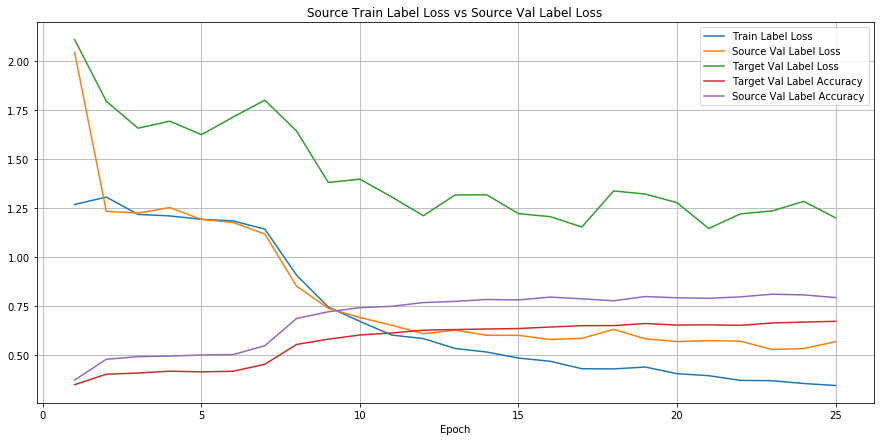

In [16]:
ax = get_loss_curve(experiment)
plt.show()

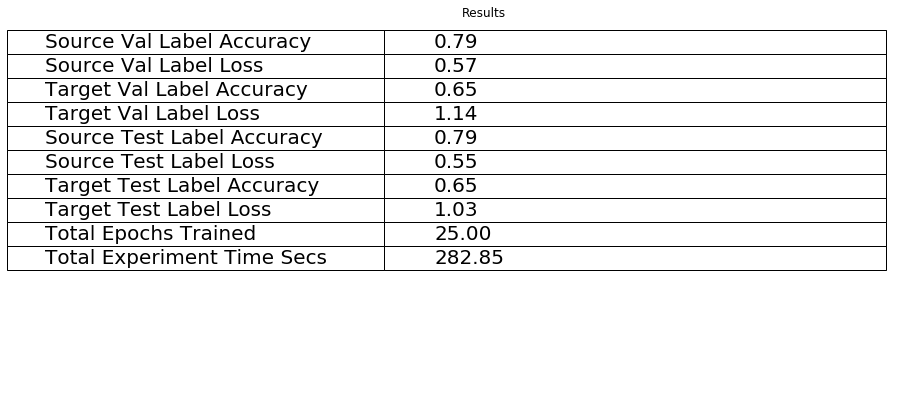

In [17]:
get_results_table(experiment)

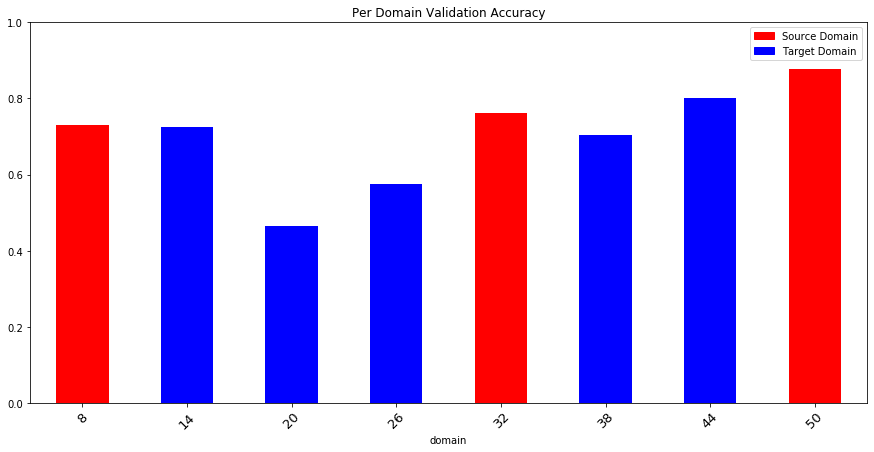

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7899305555555556 Target Test Label Accuracy: 0.65078125
Source Val Label Accuracy: 0.7890625 Target Val Label Accuracy: 0.6536458333333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "nShot_oracle.run2", "parameters": {"experiment_name": "nShot_oracle.run2", "device": "cuda", "lr": 0.001, "seed": 1337, "dataset_seed": 1337, "labels_source": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "labels_target": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "x_transforms_source": [], "x_transforms_target": [], "episode_transforms_source": [], "episode_transforms_target": [], "num_examples_per_domain_per_label_source": 1000, "num_examples_per_domain_per_label_target": 1000, "n_way": 16, "n_query": 2, "train_k_factor": 1, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_loss", "x_net": [{"class": "nnReshape", 